# Appendix III - Market Model Regression Hypothesis Test

In [1]:
import statsmodels.api as sm
import pandas as pd
from statsmodels.stats.stattools import durbin_watson

In [2]:
debt_market_df = pd.read_csv('data/debt_market_df.csv', index_col='date', parse_dates=True)

# Load debt price model
import pickle
loaded_model = pickle.load(open('debt_price_estimator.pickle', 'rb'))

features = ['beta', 'Q', 'v_1', 'v_2 + v_3', 
            'rho_star', 'C_star',
            'D_1', 'u_1', 'u_2', 'u_3', 'u_2 + u_3', 
            'D_2', 'w_1', 'w_2', 'w_3', 'w_2 + w_3',
            'D']

data_to_predict = debt_market_df[features]
loaded_model_predictions = loaded_model.predict(data_to_predict)

df = debt_market_df[['p', 'p_star']].copy()
df['p_hat'] = loaded_model_predictions
df['e_hat'] = df['p_hat'] - df['p']
df['e_star'] = df['p_star'] - df['p']
df['cumsum_e_hat'] = df['e_hat'].cumsum()
df['cumsum_e_star'] = df['e_star'].cumsum()
df['delta_e_hat'] = df['e_hat'].diff().fillna(df['e_hat'])
df['delta_e_star'] = df['e_star'].diff().fillna(df['e_star'])
df['y'] = df['p'].shift(-1)
df.dropna(inplace=True)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pyparsing.py:3172: FutureWarning: Possible set intersection at position 3
  self.re = re.compile(self.reString)


# Autocorrelation of price
Although we initially thought of modelling the market price as a set of PID controllers based on the debt price and target price errors, we later realized that it would be worth exploring the inclusion of the previous price as another component in the model. One can reason about this as "price inertia". Indeed, the Pearson correlation between the market price time series its shifted self is close to 0.7.

In [3]:
df['p'].autocorr(lag=1)

0.6957159553200067

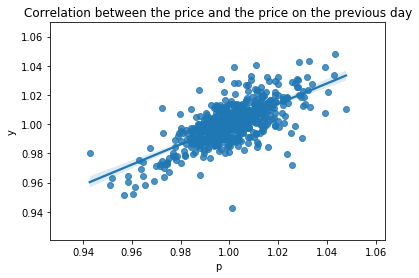

In [4]:
import seaborn as sns
sns.regplot(df['p'], df['y']).set_title(f'Correlation between the price and the price on the previous day');

Our linear model of the market price is then:

$p_{t+1} = K_0 + Kp_t + \hat{K}_p\hat{e}_t + \hat{K}_i\sum\limits_{\tau=0}^t\hat{e}_\tau + \hat{K}_d(\hat{e}_t-\hat{e}_{t-1}) + K^*_pe^*_t + K^*_i\sum\limits_{\tau=0}^te^*_\tau + K^*_d(e^*_t-e^*_{t-1})$

where:
* $\hat{e}_t = \hat{p}_t-p_t$  
* $e^*_t = p^*_t-p_t$  


## Overview

This notebook provides an Ordinary Least Squares (OLS) estimate of a linear model for the market price parameters. The OLS estimate will provide a basis for considering the goodness of fit for the model, hypothesis testing for the estimate coefficients of each parameter, and a test for autocorrelation.

## Hypotheses

The main hypotheses involve the estimate coefficents on each parameter. The Null Hypothesis for each is that there is no effect of the parameter on `y`. Our hypotheses for each coefficient is that there is an effect that is different than 0 - positive or negative.

Secondarily, we want to look at autocorrelation or the correlation between the residual/error terms in the model. Autocorrelation can bias our t-values and throw off our hypothesis testing. This is one of the key assumptions that must be satisfied in order for us to be able to trust the results of the OLS method. Fortunately, `statsmodels` provides the Durbin-Watson test for autocorrelation. The value is always between 0 and 4 where 2 indicates neither positive nor negative autocorrelation.

## Method

We use the Ordinary Least Squares (OLS) estimate of the linear model from the `statsmodel` library in Python. The input and output variables are summarized below.

In [5]:
input_vars = ['p', 
                'e_hat', 'e_star', 
                'cumsum_e_hat', 'cumsum_e_star', 
                'delta_e_hat', 'delta_e_star']
output_var = ['y']

input_data = df[input_vars]
input_data = sm.add_constant(input_data)
output_data = df[output_var]


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


### Summary Statistics

In [6]:
df.describe()

,p,p_star,p_hat,e_hat,e_star,cumsum_e_hat,cumsum_e_star,delta_e_hat,delta_e_star,y
count,651.000000,651.0,651.000000,651.000000,651.000000,651.000000,651.000000,651.000000,651.000000,651.000000
mean,1.000402,1.0,1.000311,-0.000091,-0.000402,0.048712,-0.575856,-0.000003,-0.000021,1.000386
std,0.013530,0.0,0.009929,0.010085,0.013530,0.058480,0.500354,0.010654,0.010567,0.013516
min,0.942696,1.0,0.961951,-0.034673,-0.047816,-0.134040,-1.275038,-0.040274,-0.038972,0.942696
25%,0.993778,1.0,0.995523,-0.005684,-0.007697,0.012256,-0.899639,-0.006203,-0.006203,0.993778
50%,1.000268,1.0,1.001078,0.000537,-0.000268,0.045755,-0.795639,0.000211,0.000079,1.000268
75%,1.007697,1.0,1.006522,0.005245,0.006222,0.082637,-0.115707,0.005274,0.005233,1.007649
max,1.047816,1.0,1.026005,0.057322,0.057304,0.261073,0.402621,0.058177,0.058372,1.047816


## OLS Model Results

In [7]:
ols_model = sm.OLS(output_data, input_data)
results = ols_model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.547
Method:                 Least Squares   F-statistic:                     131.6
Date:                Wed, 30 Sep 2020   Prob (F-statistic):          2.00e-108
Time:                        22:10:07   Log-Likelihood:                 2139.1
No. Observations:                 651   AIC:                            -4264.
Df Residuals:                     644   BIC:                            -4233.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2055      0.042      4.931      0.000       0.124       0.287
p                 0.7922      0.041     19.370      0.000       0.712       0.872
e_hat             0.6923      0.103      6.693      0.000       0.489       0.895
e_star           -0.5866      0.083     -7.104      0.000      -0.749      -0.424
cumsum_e_hat      0.0841      0.021      3.973      0.000       0.043       0.126
cumsum_e_star     0.0032      0.001      3.879      0.000       0.002       0.005
delta_e_hat      -0.3155      0.234     -1.349      0.178      -0.775       0.144
delta_e_star      0.4858      0.245      1.981      0.048       0.004       0.967
==============================================================================
Omnibus:                       81.285   Durbin-Watson:                   2.029
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              459.796
Skew:                          -0.373   Prob(JB):                    1.43e-100
Kurtosis:                       7.049   Cond. No.                     8.89e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.96e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## Summary

- The OLS estimate shows an R-squared of 0.551, which suggests the model inputs explain about 55% of the variance. 

In [8]:
round(results.rsquared, 3)

0.551

- The estimated coefficents show statistical significance at the 5% level for all but one of the parameters ($\hat{K}_d$), which suggests we can reject the null hypothesis for those parameters. Further iterations of this model could be done where we would remove this term from the model and compare the results. For now, this seems good enough for our purposes.

In [9]:
results.pvalues.round(3)

const            0.000
p                0.000
e_hat            0.000
e_star           0.000
cumsum_e_hat     0.000
cumsum_e_star    0.000
delta_e_hat      0.178
delta_e_star     0.048
dtype: float64

- Finally, the Durbin-Watson test of correlation between the residuals/error term shows a value close to 2, which suggests the autocorrelation is low enough to satisfy the assumptions of the OLS method. This can also be seen in a plot of the residuals.

In [10]:
durbin_watson(results.resid)

2.0294708093483385

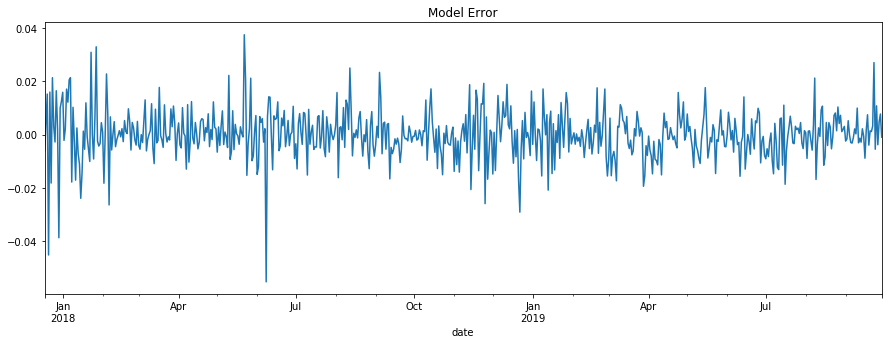

In [11]:
results.resid.plot(figsize=(15,5), title='Model Error');